In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


NUM_SEEDS = 3


def plot_cost_function(method_names, cost_lists, time_lists, matrixName):
    data = []
    data_mean = []

    assert len(method_names) * NUM_SEEDS == len(cost_lists) == len(time_lists)
    for i, method in enumerate(method_names):
        minLenCost = min([len(cost_lists[j * 4 + i]) for j in range(NUM_SEEDS)])
        minLenTime = min([len(time_lists[j * 4 + i]) for j in range(NUM_SEEDS)])
        cost_mean = np.zeros(minLenCost)
        time_mean = np.zeros(minLenTime)
        for j in range(NUM_SEEDS):
            costs = cost_lists[j * 4 + i]
            times = time_lists[j * 4 + i]
            assert len(costs) == len(times)
            cost_mean += np.array(costs[:minLenCost])
            time_mean += np.array(times[:minLenTime])
            for iteration, (cost, time) in enumerate(zip(costs, times), start=1):
                data.append([method, iteration, cost, time])
        cost_mean /= NUM_SEEDS
        time_mean /= NUM_SEEDS
        for iteration, (cost, time) in enumerate(zip(cost_mean, time_mean), start=1):
            data_mean.append([method, iteration, cost, time])

    palette = {
        "FR": plt.cm.tab10(0),
        "RS_FR": plt.cm.tab10(0),
        "L_BFGS": plt.cm.tab10(1),
        "RS_L_BFGS": plt.cm.tab10(1),
    }
    markers = {"FR": "o", "L_BFGS": "s", "RS_FR": "o", "RS_L_BFGS": "s"}
    dashes = {"FR": (5, 2), "L_BFGS": (5, 2), "RS_FR": (1, 0), "RS_L_BFGS": (1, 0)}

    df = pd.DataFrame(data, columns=["Method", "Iteration", "Cost", "Time"])
    df_mean = pd.DataFrame(data_mean, columns=["Method", "Iteration", "Cost", "Time"])

    plt.figure(figsize=(10, 6))
    sns.set_theme(style="darkgrid")

    sns.scatterplot(
        data=df,
        x="Time",
        y="Cost",
        hue="Method",
        palette=palette,
        markers=markers,
        alpha=0.05,
    )

    sns.lineplot(
        data=df_mean,
        x="Time",
        y="Cost",
        hue="Method",
        style="Method",
        palette=palette,
        dashes=dashes,
        linewidth=2,
    )

    minData = df_mean["Cost"].min()
    maxData = df_mean["Cost"][df_mean["Method"] == "RS_L_BFGS"].max()
    assert maxData > minData

    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Stress", fontsize=12)
    plt.ylim(minData - (maxData - minData) * 0.1, maxData + (maxData - minData) * 1.1)
    plt.title("Cost Function per Iteration", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plot/{matrixName}.pdf")
    plt.show()

In [65]:
def parse_hist_file(file_path):

    data = {}
    with open(file_path, "r") as file:
        num_matrices, num_methods = map(int, file.readline().strip().split())

        for _ in range(num_matrices):
            matrix_name = file.readline().strip()
            data[matrix_name] = {}

            for _ in range(num_methods):
                method_name = file.readline().strip()
                data[matrix_name][method_name] = {}
                for idx in range(NUM_SEEDS):
                    data[matrix_name][method_name][idx] = {}
                    _hist_size = int(file.readline().strip())
                    hist = list(map(float, file.readline().strip().split()))
                    data[matrix_name][method_name][idx]["history"] = hist
                    time = list(map(float, file.readline().strip().split()))
                    data[matrix_name][method_name][idx]["time"] = time
                    time_line = file.readline().strip()
                    avg_time = float(time_line.split(": ")[1])
                    data[matrix_name][method_name][idx]["elapsed_time"] = avg_time
                    score_line = file.readline().strip()
                    avg_score = float(score_line.split(": ")[1])
                    data[matrix_name][method_name][idx]["score"] = avg_score

    return data

In [66]:
file_path = "hist.txt"
parsed_data = parse_hist_file(file_path)
print(parsed_data.keys())

dict_keys(['cycle300', 'jagmesh1', 'btree9', '1138_bus', 'dwt_1005', 'dwt_2680', '3elt'])


cycle300


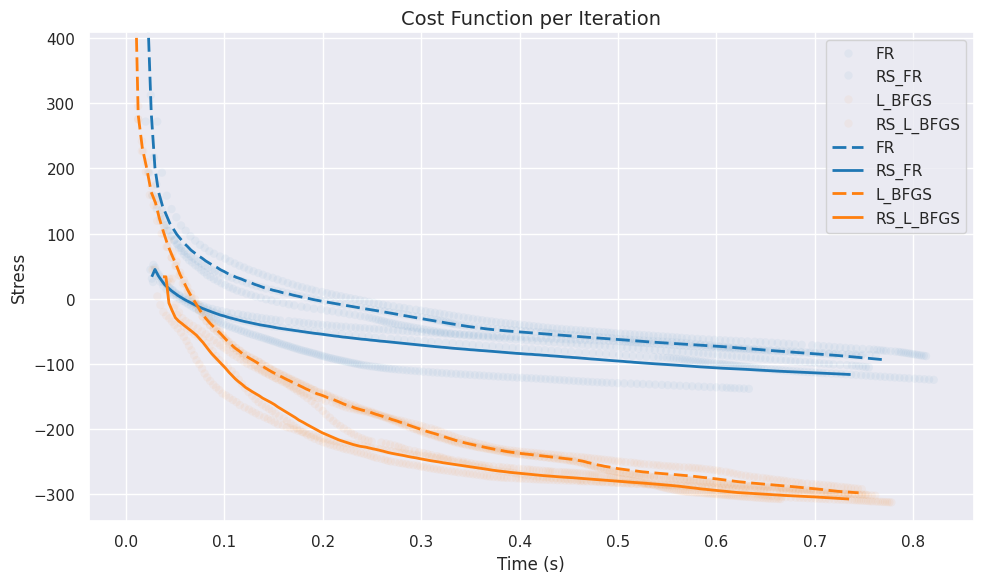

jagmesh1


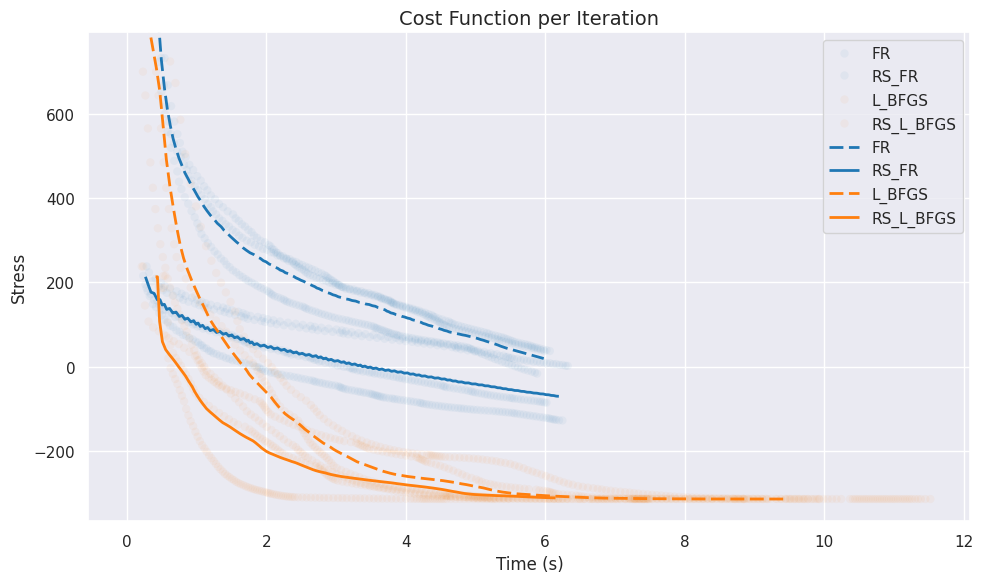

btree9


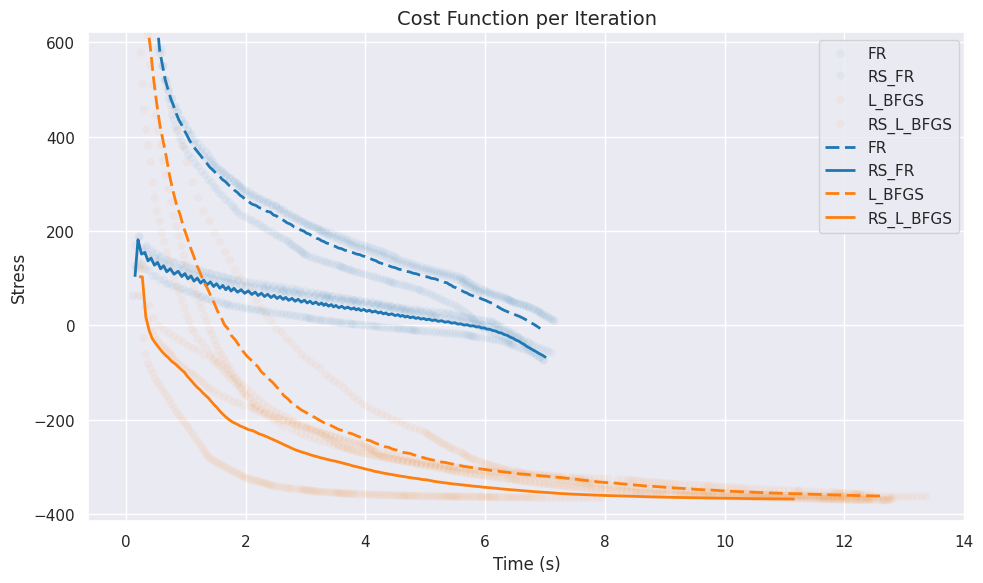

1138_bus


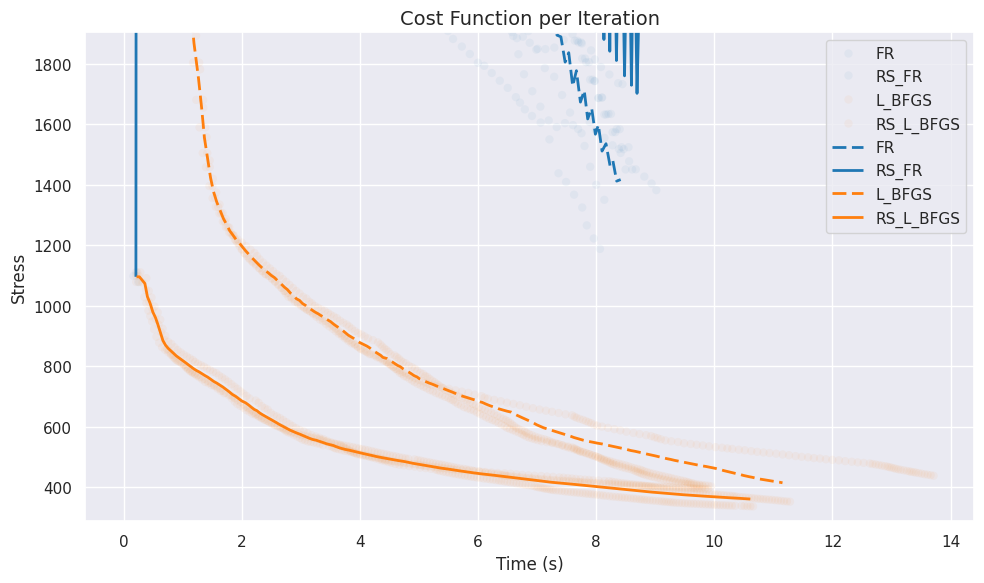

dwt_1005


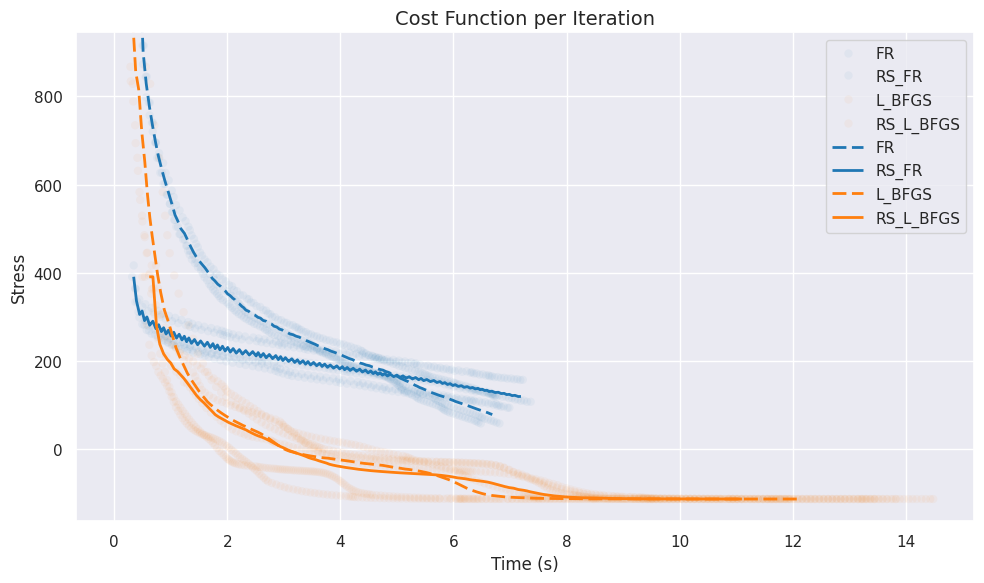

dwt_2680


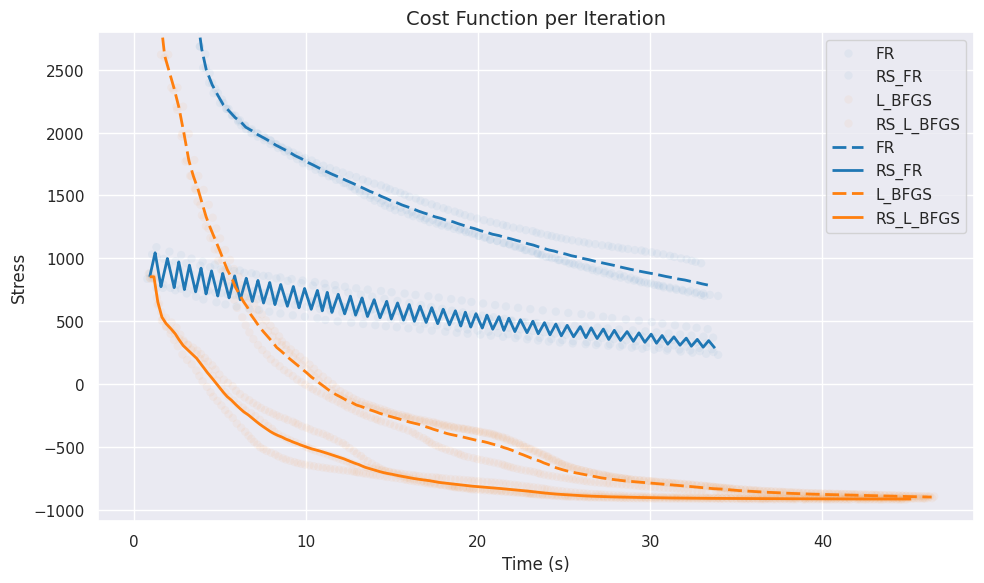

3elt


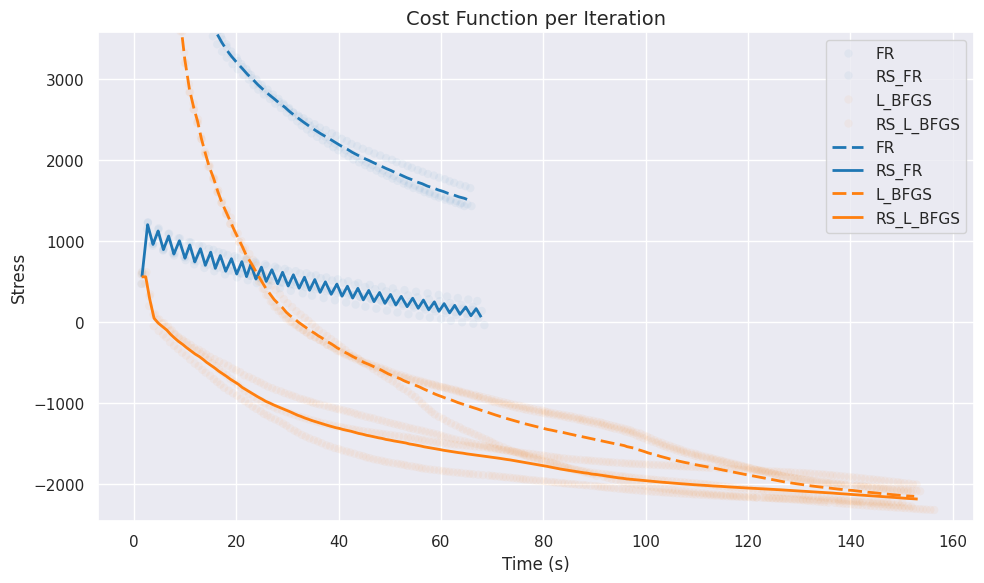

In [67]:
for matrixName in parsed_data:
    print(matrixName)
    methods = parsed_data[matrixName].keys()
    costs = [
        parsed_data[matrixName][method][idx]["history"]
        for idx in range(NUM_SEEDS)
        for method in methods
    ]
    times = [
        parsed_data[matrixName][method][idx]["time"]
        for idx in range(NUM_SEEDS)
        for method in methods
    ]
    plot_cost_function(methods, costs, times, matrixName)